## Background:

Following on this github issue (https://github.com/livepeer/research/issues/17), particularly on the Video Quality Checking topic:
> There are various easily checkable properties that can be extracted from the video itself such as the codec, the resolution, timestamps, and perhaps certain other bitstream features. However those properties alone do not ensure an important aspect of verification: that the transcoded content itself is a reasonable match for the original source given a good-faith effort at transcoding.

> What is a "reasonable match" and what is a "good-faith effort at transcoding"? Some problems with the video may include:
   -  Watermarking or other manipulation of the source content
   -  Uncalled for resolution changes mid-stream
   -  Excessive frame dropping
   -  Low quality encoder or inappropriate encoding settings

> What criteria should we be checking addition to video quality?
   -  Codec and container itself
   -  Timestamps
   -  Any metadata?


The aim of this notebook is to give an answer to the following set of questions raised in the context of finding an objective metric to assess the quality of stream videos:

-  How to use these per-frame scores for video
-  How to incorporate these scores into a pass/fail classifier?
-  What does each contribute towards the classifier?
-  How are these affected by variations in input and output?
-  How is verification affected if either metric is removed from the equation?
-  Can we extrapolate the behavior of these metrics across unknown inputs? What are the boundaries?
-  What is the performance/computational impact of incorporating these metrics into the classifier? Can this be run online within our sub-2s latency budget?



## Methodology:

We have created a dataset with 140 videos collected from the YT8M dataset using our tool from previous research (https://github.com/epiclabs-io/YT8M).

These 140 are basically those with a set of at least four renditions codified in H264 (240, 360, 480, 720 and 1080).
In order to depart from the null hypothesis that video is transcoded correctly, this seems like a very good assumption as it is in YouTube's own interest to be so.

In order to extend the list of possible metrics, we have researched a few candidates based on the perceptual hashing of the original and the codified videos: cosine distance, euclidean distance and Hamming distance.


# CODE

### Import necessary libraries

In [ ]:
import pandas as pd
import plotly.plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

### Retrieve data, group it and normalize it

In [ ]:
# Retrieve data from repo
metrics_df = pd.read_csv('../output/metrics.csv')
metrics_df = metrics_df.drop(['Unnamed: 0'], axis=1)
metrics_df['title'] = metrics_df['level_0']
# Group values for each title
metrics = ['cosine', 'euclidean', 'hamming', 'psnr', 'ssim', 'vmaf', 'ms-ssim']
grouped_df = metrics_df.groupby(['level_1'] + metrics + ['title'], as_index=False).count()

# Normalize the values between 0 and 1
#for metric in metrics:
#    grouped_df[metric] = (grouped_df[metric]-grouped_df[metric].min())/(grouped_df[metric].max()-grouped_df[metric].min())

In [ ]:
# Function to create a plot from columns of a pandas DataFrame
def plot_metric(metric, grouped_df):
    x_data = grouped_df['level_1']
    y_data = grouped_df[metric]

    trace1 = go.Histogram2dContour(x=x_data,
                                   y=y_data,
                                   contours=dict(coloring='heatmap'))
    trace2 = go.Scatter(x=x_data,
                        y=y_data,
                        mode='markers',
                        marker=dict(color='blue',
                                    size=3,
                                    opacity=0.3),
                        text=grouped_df['title'],
                       hoverinfo='text')
    data = [trace1,trace2]
    layout = {"title": "Video metrics disparity: {}".format(metric), 
          "xaxis": {"title": "Rendition", }, 
          "yaxis": {"title": "Metric value"},
             "hovermode":"closest"}
    fig = go.Figure(data=data, layout=layout)
    offline.iplot(fig)

In [ ]:
# Iterate through each metric and obtain the respective charts
for metric in metrics:
    plot_metric(metric, grouped_df)

# DISCUSSION

## Cosine distance

This distance is measured over the hash created by reducing a grayscale version (luminance space) of each frame (original and codified) to a 16x16 pixel image, then obtaining a 15 bit hash and computing their cosine distance.

## Euclidean distance

This distance is measured over the hash created by reducing a grayscale version (luminance space) of each frame (original and codified) to a 16x16 pixel image, then obtaining a 15 bit hash and computing their euclidean distance.

## Hamming distance
This distance is measured over the hash created by reducing a grayscale version (luminance space) of each frame (original and codified) to a 16x16 pixel image, then obtaining a 15 bit hash and computing their euclidean distance.

## PSNR

PSNR is computed over the grayscale of both reference and codified using the psnr function in the video_asset_processor.py module.

## SSIM
This metric is obtained using the implementation available in skimage.measure over the luminance space (grayscale) of both the origin and the codified version.

# CONCLUSIONS

As it is explained here: https://link.springer.com/article/10.1007/s11042-017-4831-6,
the metrics above can be categorized as objective Full Reference metrics for Video Quality Assessment.
We would reccomend to use other type of metrics, as described in the above reference, and use an unsupervised approach given the complexity of the problem at hand.


#### How to use PSNR / SSIM (per-frame scores) for video (sequence of frames)?

Good characterization of time series is achieved by wisely using statistical techniques (average, histograms, wavelets, etc.) that can summarize the properties of a sequence. In this case we have extracted the mean value for all metrics.
However, the main issue will not be just the extrapolation of a per frame metric (PSNR, MS-SSIM, MSE, entropy, etc.) to a time series sequence of frames.
The most complicated part comes when we need to define what is a "good" configuration of those time series.  

#### How to incorporate these scores into a pass/fail classifier? What does each contribute towards the classifier?

As pointed out above, by simple measurement of different instantaneous metrics there is no way one can do this. We could potentially define acceptable thresholds for that ratio for given renditions and bitrates / encoding parameters, but they would remain arbitrary.

#### How are these affected by variations in input and output?

In the figures above, we can appreciate that different sequences of frames (186 assets extracted from YouTube) with different configurations give slightly different results, although SSIM seems to be the one with the least dispersion.


#### How is verification affected if either metric is removed from the equation? Can we extrapolate the behavior of these metrics across unknown inputs? What are the boundaries?

As it is shown in the charts, the mean values for each metric are sensitive to different kinds of encoding and video characteristics. This leads one to think that (as it is explained in literature) different metrics are sensitive to different kinds of inputs. This renders them unsuitable for actual training of a supervised machine learning algorithm, given the amplitude of the space of possible ground truths.


#### What is the performance/computational impact of incorporating these metrics into the classifier? Can this be run online within our sub-2s latency budget?


Figure below shows the (more or less) constant elapsed time required to compute both PSNR and SSIM between the original frame and the frames generated at 500Kbps and 250Kbps.

This gives an overhead (in our implementation, using skimage's compare_ssim) of about 0.172s per frame (=4s for 24 frames) for Big Buck Bunny.

Obviously, there is no particular need to catch every single frame, and more efficient implementations could be found.


Big Buck Bunny:

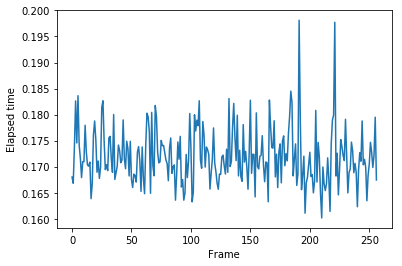




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# From https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
data = grouped_df[metrics]
corr = data.corr('spearman')
corr.style.background_gradient().set_precision(2)
corr.style.background_gradient(cmap, axis=1)


In [ ]:
import scipy.stats as stats
from sklearn.cluster import KMeans
import seaborn as sns


sns.pairplot(metrics_df[metrics])

In [ ]:
from matplotlib.mlab import PCA

def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n=coeff.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color='g', ha='center', va='center')

plt.figure(figsize=(15, 10))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

# test
pca_out=PCA(metrics_df[metrics])
biplot(pca_out.Y[:,0:2],pca_out.Wt[:,0:2], labels=metrics_df[metrics].columns)
plt.show()




In [ ]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA
from plotly import tools

df_tr_std = stats.zscore(metrics_df[metrics])
#Cluster the data
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_tr_std)
labels = kmeans.labels_
metrics_df['clusters'] = labels

X = metrics_df[metrics]
y = labels

n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ['navy', 'turquoise', 'darkorange', 'green', 'red', 'yellow']

col = 1
legend = True

data = []
for color, i in zip(colors, [0, 1]):

    pca = go.Scatter(x=X_pca[y == i, 0], 
                     y=X_pca[y == i, 1],
                     showlegend=True,
                     mode='markers',
                     marker=dict(color=color), 
                     text=grouped_df['title'],
                    hoverinfo='text'
                    )
    data.append(pca)
    
    layout = {"title": "Video metrics PCA", 
          "xaxis": {"title": "Principal Component 1", }, 
          "yaxis": {"title": "Principal Component 2"},
             "hovermode":"closest"}
fig = go.Figure(data=data, layout=layout)
    

    
offline.iplot(fig)

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 1000)
display(metrics_df)